# Ejercicios Pair Programming 
## Lección 11 - Regresión Lineal Decision Tree

En el pair programming de hoy debéis usar el csv que guardastéis cuando hicistéis el pairprgramming de codificicación (este csv debería tener las variables estadandarizas).

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [2]:
df = pd.read_csv("supermercado_encoding.csv", index_col=0)

In [3]:
df.head()

,income,numdealspurchases,numstorepurchases,numwebvisitsmonth,numwebpurchases_sklearn,marital_status_oe
0,1.608976,-0.701068,0.052191,-1.803407,0.363636,7.0
1,0.264394,-0.701068,0.361131,-0.142553,0.636364,3.0
2,0.757562,-0.701068,-0.256748,-1.388194,0.272727,6.0
3,-0.928642,-0.701068,-1.183568,0.687874,0.090909,5.0
4,-1.461745,-0.170569,-1.183568,0.687874,0.272727,3.0


En pairprogramming anteriores ajustastéis vuestro datos a una regresión lineal. El objetivo de hoy es:

Ajustar el modelo a un Decision Tree

In [6]:
# Separamos nuestra dataframe en dos al igual que en la Regresión Lineal.

X = df.drop("numwebpurchases_sklearn", axis = 1)
y = df["numwebpurchases_sklearn"]

In [7]:
# Dividimos nuestros datos en train y test.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
# Creamos el objeto del modelo.
arbol = DecisionTreeRegressor(random_state =0)

# Ajustamos el modelo.
arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

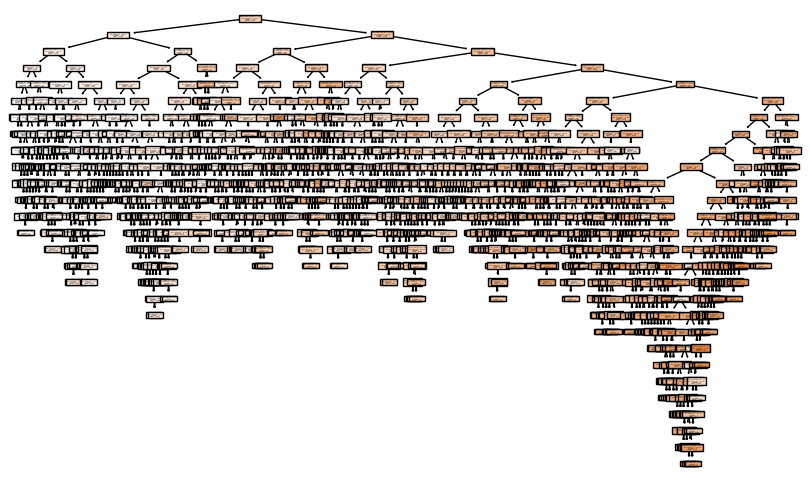

In [10]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

Observando la gráfica vemos que presenta overfitting, por lo que reduciremos la profundidad de nuestro modelo. Para esto tendremos que ver el parámetro "max_features" que nos dice la raíz cuadrada del número de variables predictoras y el parámetro "max_depth" que nos dice cuántos hijos tiene nuestro árbol de decisión.

In [11]:
# Realizamos la raíz cuadrada de max features para ver la profundidad de nuestro modelo. 

max_features = np.sqrt(len(x_train.columns))
max_features

2.23606797749979

In [12]:
# Vemos también el parámetro max_depth

print(arbol.tree_.max_depth)

27


Aunque gráficamente ya nos dice que tiene overfitting, realizaremos la predicción para ver las métricas de nuestro modelo y confirmar analíticamente lo visto en la gráfica.

In [13]:
# Hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [14]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [15]:
# Sacamos los resultados de las métricas

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1.043150e-01,3.244849e-02,1.801346e-01,0.417782,test,Decission Tree I
1,2.748315e-18,1.582332e-34,1.257908e-17,1.000000,train,Decission Tree I


Comprobando de forma analíticas las métricas de nuestro modelo, nos reafirmamos que hay overfitting ya que el train es mucho mejor que el test, es decir, las métricas están mucho mas bajas en el train que en el test, excepto en el R2 que están mucho más altas. En este caso nuestro modelo se están aprendiendo de memoria los datos de entrenamiento y no sería capaz de hacer buenas predicciones fuera de este test.

Procederemos a reducir la profundidad del modelo usando GridSearchCV que nos realizará todas las posibles combinaciones de los hiperparámetros que vamos a cambiar.

In [17]:
df.shape

(2166, 6)

In [18]:
# Definimos un diccionario con los hiperparámetros que vamos a modificar.

param = {"max_depth": [4,6,8], 
        "max_features": [1,2,3],
        "min_samples_split": [20, 60, 200],
        "min_samples_leaf": [10,30,100]} 

In [19]:
# Iniciamos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param, 
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [20]:
# Ajustamos el modelo 

gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 6, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 30, 100],
                         'min_samples_split': [20, 60, 200]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [21]:
# Ejecutamos "best_estimator_" para quedarnos con el mejor modelo que nos ha generado GridSearchCV a través de todas las
# combinaciones posibles que ha realizado.
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=10,
                      min_samples_split=20)

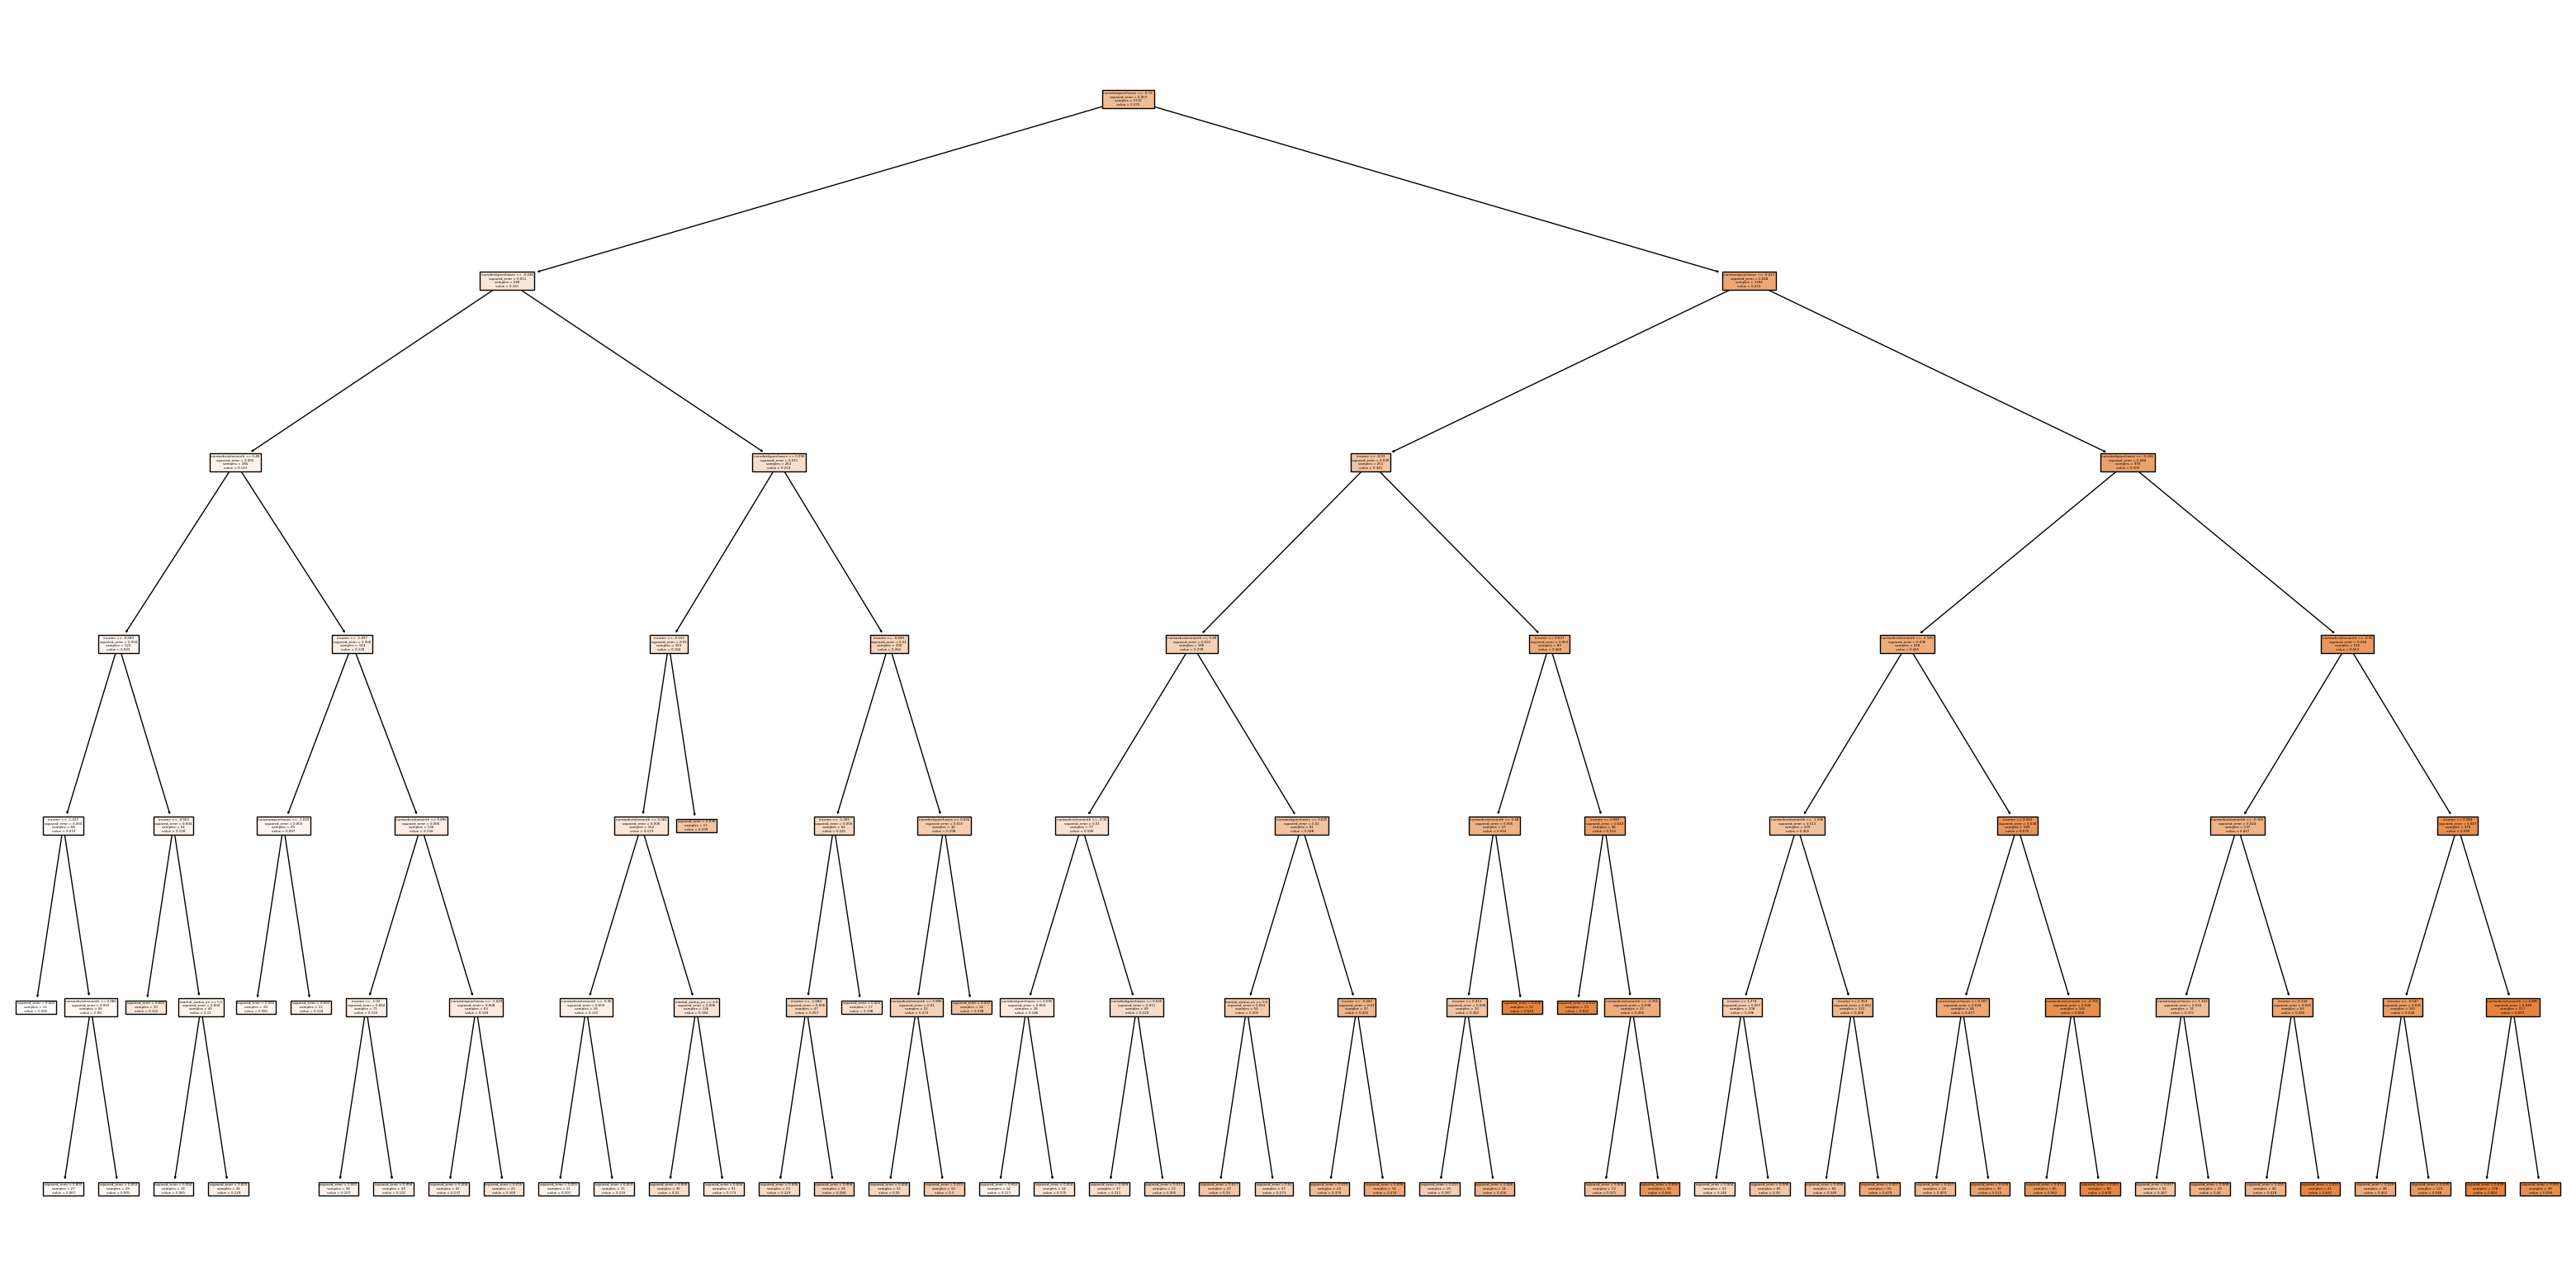

In [22]:
# Observamos con la gráfica de árbol la variable "mejor_modelo"

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [23]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

Extraer las métricas

In [24]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.100601,0.020164,0.142001,0.638194,test,Decision tree II
1,0.098692,0.019269,0.138814,0.662455,train,Decision tree II


In [25]:
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.043150e-01,3.244849e-02,1.801346e-01,0.417782,test,Decission Tree I
1,2.748315e-18,1.582332e-34,1.257908e-17,1.000000,train,Decission Tree I
0,1.006009e-01,2.016438e-02,1.420013e-01,0.638194,test,Decision tree II
1,9.869192e-02,1.926934e-02,1.388141e-01,0.662455,train,Decision tree II


Observamos que nuestros resultados están mucho más ajustados, por lo que ya no hay overfitting y el modelo es mucho más fiable y será capaz de predecir y dar buenos resultados cuando se le añadan datos.

### Comparación de métricas de Regresión Lineal y Decision Tree I y II

In [27]:
df_regresion_lineal = pd.read_csv("supermercado_metricas.csv", index_col = 0)
df_regresion_lineal

,MAE,MSE,RMSE,R2,set,modelo
0,0.117877,0.028165,0.167825,0.494634,test,Linear Regresion
1,0.122189,0.026079,0.161489,0.543177,train,LinearRegression


In [28]:
df_final = pd.concat([df_regresion_lineal, df_decision_results], axis = 0)
df_final

,MAE,MSE,RMSE,R2,set,modelo
0,1.178767e-01,2.816536e-02,1.678254e-01,0.494634,test,Linear Regresion
1,1.221892e-01,2.607855e-02,1.614886e-01,0.543177,train,LinearRegression
0,1.043150e-01,3.244849e-02,1.801346e-01,0.417782,test,Decission Tree I
1,2.748315e-18,1.582332e-34,1.257908e-17,1.000000,train,Decission Tree I
0,1.006009e-01,2.016438e-02,1.420013e-01,0.638194,test,Decision tree II
1,9.869192e-02,1.926934e-02,1.388141e-01,0.662455,train,Decision tree II


Debatid entre vosotras que modelo es mejor y por qué (basándose en las métricas)

Basándonos en las métricas de los tres modelos de regresión se aprecia claramente que el más efectivo es el modelo "Decision Tree II". Sus valores entre el train y el test están muy ajustados, hay poca diferencia entre ellos, cosa que no pasa en el Decision Tree I. 

En cuanto a la comparación con el modelo "Linear Regression" consideramos que las métricas "MAE", "MSE" y "RMSE" no poseen una gran diferencia entre ambas, siendo éstas bajas en ambos casos. Nos decantamos por "Decision Tree II" ya que su valor de R2 es más elevado en esta métrica que en "Linear Regression", lo que nos da un mayor porcentaje de probabilidades de acierto.

In [29]:
df_final.to_csv("supermercado_metricas_tree_linear.csv")

### Importancia de las variables predictoras en nuestro modelo

In [30]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )


importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,numstorepurchases,0.646125
3,numwebvisitsmonth,0.182707
0,income,0.102825
1,numdealspurchases,0.066740
4,marital_status_oe,0.001603


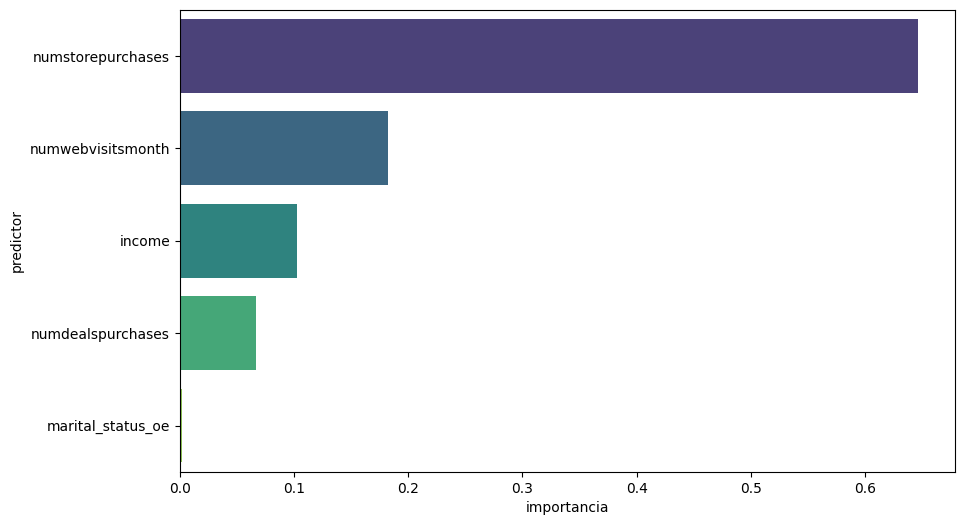

In [31]:
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

Para nuestra sorpresa vemos que la variable que considerábamos más importante a la hora de la predecir las compras online ha pasado a un tercer lugar, es decir, los ingresos no es la variable predictora más importante sino el número de compras en tienda. 

Con estos datos que nos da la gráfica suponemos que la encuesta fue respondida por mas gente de manera presencial que online, es decir, dicha encuesta se ha hecho en el propio supermercado (por lo que ya dichos encuestados están comprando físicamente en el supermercado y hacen además compras online) y suponemos que también se ha ofertado para responder online aunque no ha habido la misma aceptación en este medio.

Happy coding💪🏽